In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sdss = pd.read_csv("/Users/luciano/Downloads/sdss_sample.csv", sep=';')
sdss = sdss.set_index('objid')

In [4]:
description = sdss.describe()
description

,skyversion,run,rerun,camcol,field,obj,mode,nchild,type,clean,...,nmgypercount_g,nmgypercount_r,nmgypercount_i,nmgypercount_z,tai_u,tai_g,tai_r,tai_i,tai_z,row_id
count,59889.0,59889.000000,59889.0,59889.000000,59889.000000,59889.000000,59889.000000,59889.0,59889.000000,59889.000000,...,59889.000000,59889.000000,59889.000000,59889.000000,5.988900e+04,5.988900e+04,5.988900e+04,5.988900e+04,5.988900e+04,59889.000000
mean,2.0,629.165489,301.0,3.542687,224.181452,762.087946,1.678572,0.0,4.697340,0.214898,...,0.003618,0.004810,0.006805,0.032644,4.429556e+09,4.429557e+09,4.429556e+09,4.429556e+09,4.429557e+09,29945.000000
std,0.0,328.999233,0.0,1.702212,188.592404,630.771869,0.467029,0.0,1.491314,0.410755,...,0.005997,0.001687,0.001901,0.019972,1.202920e+07,1.202920e+07,1.202920e+07,1.202920e+07,1.202920e+07,17288.609473
min,2.0,94.000000,301.0,1.000000,11.000000,2.000000,1.000000,0.0,0.000000,0.000000,...,0.002962,0.003676,0.004683,0.021603,4.412900e+09,4.412900e+09,4.412900e+09,4.412900e+09,4.412900e+09,1.000000
25%,2.0,287.000000,301.0,2.000000,75.000000,348.000000,1.000000,0.0,3.000000,0.000000,...,0.003478,0.004662,0.006383,0.031273,4.418345e+09,4.418345e+09,4.418345e+09,4.418345e+09,4.418345e+09,14973.000000
50%,2.0,745.000000,301.0,4.000000,155.000000,613.000000,2.000000,0.0,6.000000,0.000000,...,0.003581,0.004764,0.006553,0.032561,4.428644e+09,4.428644e+09,4.428644e+09,4.428644e+09,4.428644e+09,29945.000000
75%,2.0,1000.000000,301.0,5.000000,365.000000,981.000000,2.000000,0.0,6.000000,0.000000,...,0.003686,0.004840,0.006770,0.035917,4.445994e+09,4.445994e+09,4.445994e+09,4.445994e+09,4.445994e+09,44917.000000
max,2.0,1057.000000,301.0,6.000000,812.000000,5475.000000,2.000000,0.0,6.000000,1.000000,...,1.405500,0.210628,0.160921,2.265100,4.446786e+09,4.446786e+09,4.446786e+09,4.446786e+09,4.446786e+09,59889.000000


In [5]:
to_drop = description.columns[description.loc['min'] == description.loc['max']]
sdss = sdss.drop(to_drop, axis=1)

In [6]:
print("Are there any missing values: ", any(description.loc['count'] != len(sdss)))

Are there any missing values:  False


In [8]:
from sklearn.preprocessing import StandardScaler
from src.user import DummyUser

def get_linear_query(sdss, dim, max_iter):
    cols = ['rowc', 'colc', 'ra', 'dec', 'tai_z', 'tai_r']
    cols = cols[:dim]
    
    scaler = StandardScaler()
    X = scaler.fit_transform(sdss[cols].values) + 1.4
    
    y = (X[:,0] + X[:,1] < 0)
    y = 2*y - 1
    print('selectivity: {0:.2}%'.format(100*np.sum(y == 1)/len(y)))
    
    return X, DummyUser(max_iter=max_iter, y_true=y)

X, user = get_linear_query(sdss, 2, 100)
y = user.y_true

selectivity: 1.8%


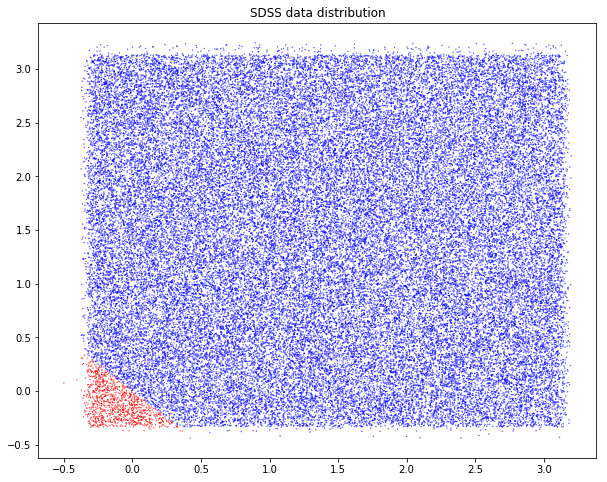

In [9]:
plt.figure(figsize=(10,8))
plt.title("SDSS data distribution")
plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'r' if x == 1 else 'b', y)), s=0.1)
plt.show()

In [10]:
# testing that data is linearly separable
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score

clf = LinearSVC(C=1000, fit_intercept=False)
clf.fit(X, y)
print("Final F-score of Linear SVM model: ", f1_score(y_pred=clf.predict(X), y_true=y))

Final F-score of Linear SVM model:  0.999525841631


selectivity: 1.8%
selectivity: 1.8%
selectivity: 1.8%
Running time per run (in minutes): 0.41633327094713846


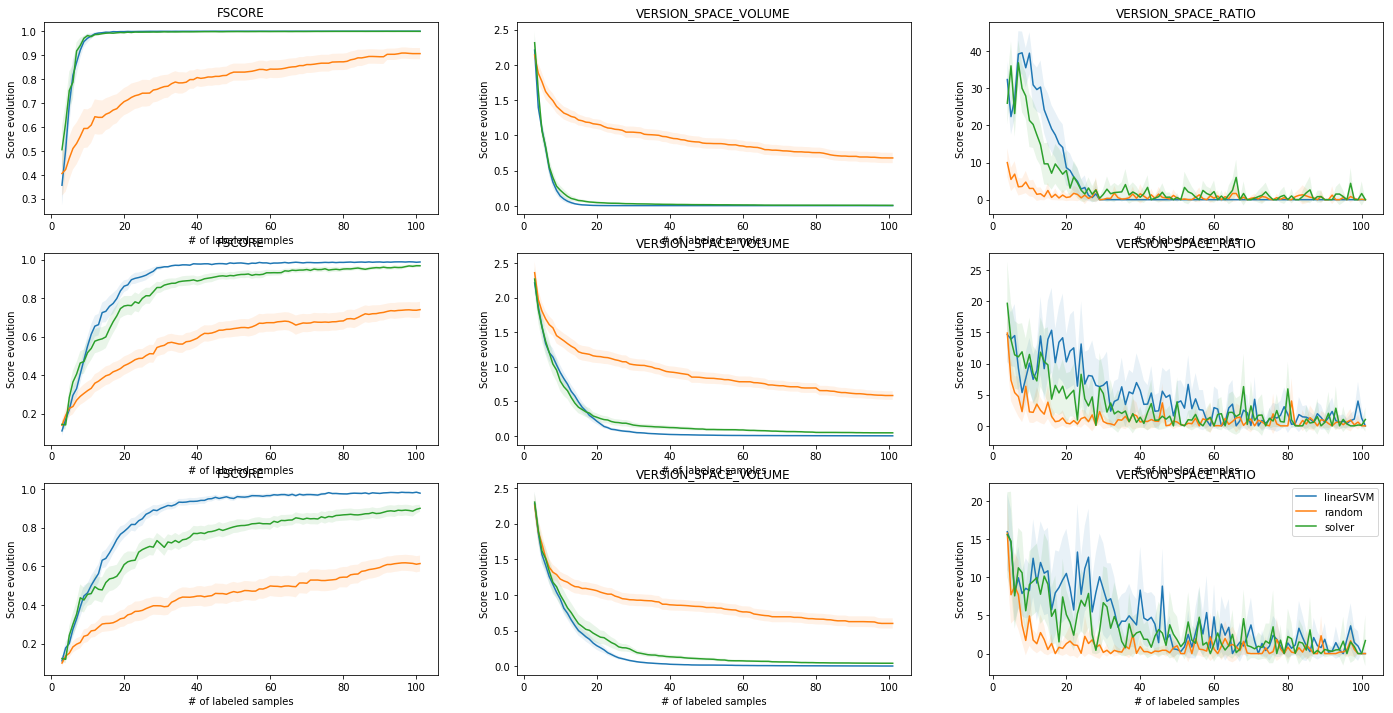

In [32]:
from time import time
from src.user import DummyUser
from src.initial_sampling import FixedSizeStratifiedSampler
from src.showdown import Showdown
from src.plotting import plot_showdown

from src.active_learning.svm import SimpleMargin, SolverMethod
from src.active_learning.agnostic import RandomLearner
from src.version_space.two_dimensional import Circle

# set user
max_iter = 100
user = DummyUser(max_iter=max_iter, y_true=y)

# AL list
active_learners_list = [
     ("random", RandomLearner(LinearSVC(C=1000, fit_intercept=False), Circle())),
     ("linearSVM", SimpleMargin(kind='linear', C=1000, kernel='linear', fit_intercept=False)),
     ("solver", SolverMethod(kind='linear', pool_size=100, C=1000, kernel='linear', fit_intercept=False)),
]

# datasets
dim_list = [2,4,6]
data_and_user = [get_linear_query(sdss, dim, max_iter) for dim in dim_list]
datasets_list = [("sdss_" + str(dim), X, user) for dim, (X, user) in zip(dim_list, data_and_user)]

# set showdown and run
times = 50
initial_sampler = FixedSizeStratifiedSampler(sample_size=2)

t0 = time()
showdown = Showdown(times, initial_sampler)
output = showdown.run(datasets_list, active_learners_list)
print("Running time per run (in minutes):", (time() - t0)/(60*times))

# plot results
#print(output.head())
plot_showdown(output, times, metrics_list=['fscore', 'version_space_volume', 'version_space_ratio'])

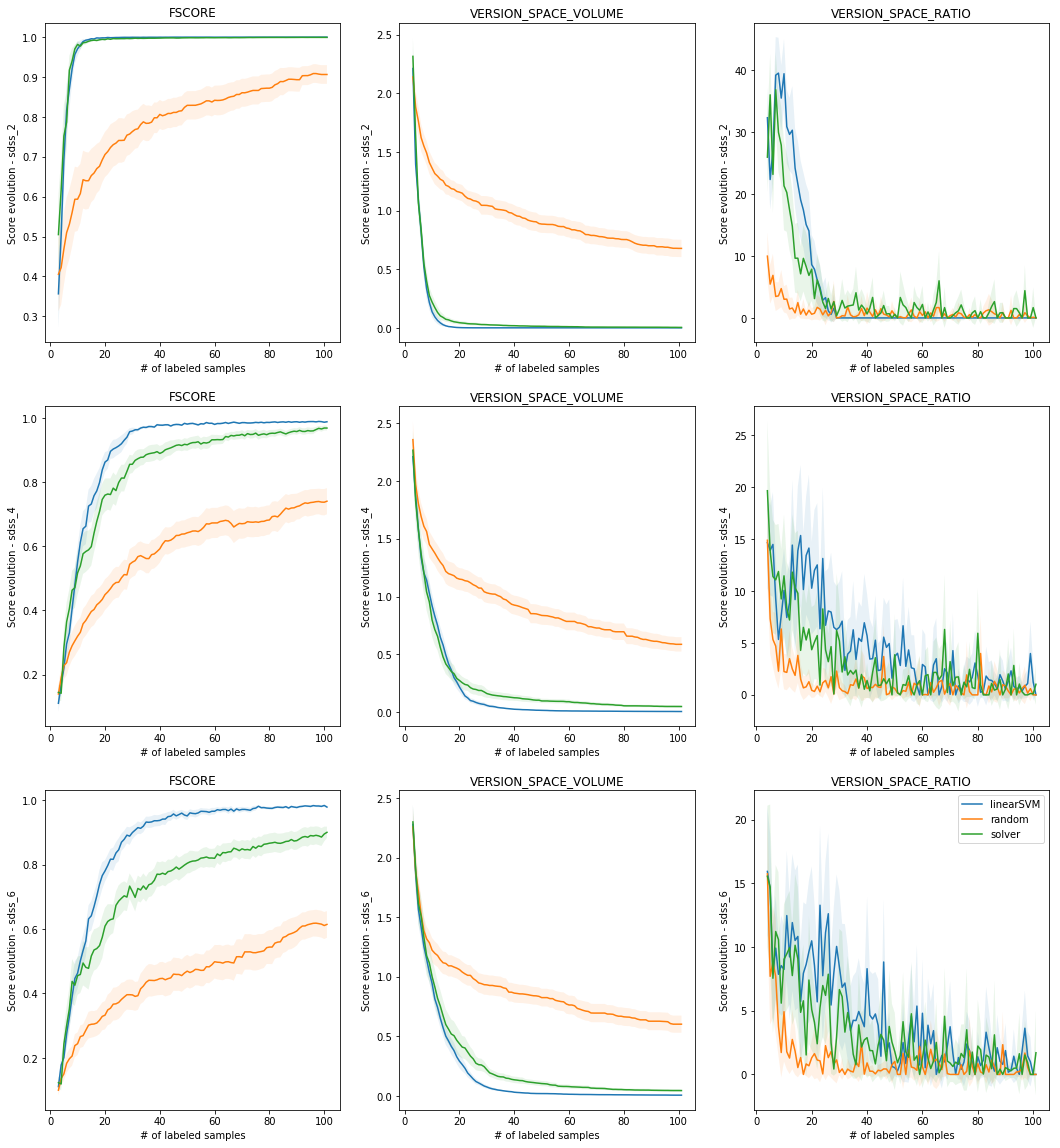

In [34]:
from math import sqrt
def plot_showdown(output, times, metrics_list=None):
    data_tags = output.columns.levels[0]

    if metrics_list is None:
        metrics_list = output.columns.levels[1]
    als = output.columns.levels[2]

    fig, axs = plt.subplots(len(data_tags), len(metrics_list))
    if len(data_tags) == 1:
        axs = [axs]

    fig.set_size_inches(18, 20)

    for i, ds in enumerate(data_tags):
        for j, name in enumerate(metrics_list):
            ax = axs[i][j]
            ax.set_title(name.upper())
            ax.set_xlabel("# of labeled samples")
            ax.set_ylabel("Score evolution - " + ds)

            for al in als:
                df = output[ds][name][al]
                x = df.index
                y = df['mean']
                error = 1.96 * df['std'] / sqrt(times)
                ax.plot(x, y, label=al)

                ax.fill_between(x, y - error, y + error, alpha=0.1)

    plt.legend()
    plt.show()
    
plot_showdown(output, times, metrics_list=['fscore', 'version_space_volume', 'version_space_ratio'])